In [19]:
import re
import random
import pathlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install -q -U cytoolz
!pip install -q -U spacymoji

import spacy
import cytoolz
from spacymoji import Emoji
from spacy.compat import pickle

SPACY_CORE_MODEL = 'es_core_news_md'
spacy.cli.download(SPACY_CORE_MODEL)

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime/data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Sentime/data


In [0]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.utils import resample

def balance_dataset(df, order):
    class_distribution = df['sentiment'].value_counts()
    minority_shape = df[df.sentiment == order[0]].shape[0]

    df_list = [df[df.sentiment == order[0]]]
    for cls in order[1:]:
        df_temp = df[df.sentiment == cls]
        df_down_sample = resample(df_temp, replace=False, n_samples = minority_shape,
                                   random_state=123)
        df_list.append(df_down_sample)

    df_downsampled = pd.concat(df_list)
    # shuffle
    df_downsampled = df_downsampled.sample(frac = 1)
    df_downsampled.reset_index(drop=True, inplace=True)
    return df_downsampled

def plot_classes_proportion(df, title="train classes proportion"):
    plot_data = df['sentiment'].value_counts()
    x = plot_data.index.values
    y = plot_data.values

    plt.figure(figsize=(8,5))
    fig = sns.barplot(x=x, y=y, orient="v", palette="hls")

    plt.ylabel('Number of tweets')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def read_data(data_dir, title, balance=False, limit=0):
    dataset = pd.read_csv(data_dir / 'data.csv')

    plot_classes_proportion(dataset, title)
    dataset = dataset[dataset['sentiment'] != 'MIXED']

    if balance:
      ORDER = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
      dataset = balance_dataset(dataset, order=ORDER)
      plot_classes_proportion(dataset, "Balanced train classes proportion")

    tweets = [str(tweet) for tweet in dataset['tweet']]

    sentiments = LabelEncoder()
    sentiments = sentiments.fit_transform(dataset['sentiment'])
    sentiments = to_categorical(sentiments)

    examples = zip(tweets, sentiments)
    examples = list(examples)

    if limit >= 1:
      examples = examples[:limit]

    return zip(*examples)  # Unzips into two lists

def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, np.asarray(labels, dtype='f')

def get_features(docs, max_length):
    docs = list(docs)
    Xs = np.zeros((len(docs), max_length))
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [0]:
batch_size=128

class SentimentAnalyser():
    @staticmethod
    def get_embeddings(vocab):
      return vocab.vectors.data

    @classmethod
    def load(cls, nlp, model, lstm_weights, max_length=140):
      embeddings = cls.get_embeddings(nlp.vocab)
      model.set_weights([embeddings] + lstm_weights)
      return cls(model, max_length=max_length)

    @classmethod
    def predict(cls, nlp, texts):
      docs = nlp.pipe(texts, batch_size=batch_size)
      return [doc.sentiment for doc in docs]

    def __init__(self, model, max_length=140):
      self._model = model
      self.max_length = max_length

    def __call__(self, doc):
      X = get_features([doc], self.max_length)
      y = self._model.predict(X)
      self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=batch_size):
      for minibatch in cytoolz.partition_all(batch_size, docs):
          minibatch = list(minibatch)
          sentences = []
          for doc in minibatch:
              sentences.extend(doc.sents)
          Xs = get_features(sentences, self.max_length)
          ys = self._model.predict(Xs)
          for sent, label in zip(sentences, ys):
              sent.doc.sentiment += np.argmax(label) - 1
          for doc in minibatch:
              yield doc

    def set_sentiment(self, doc, y):
      doc.sentiment = y

Reading data...


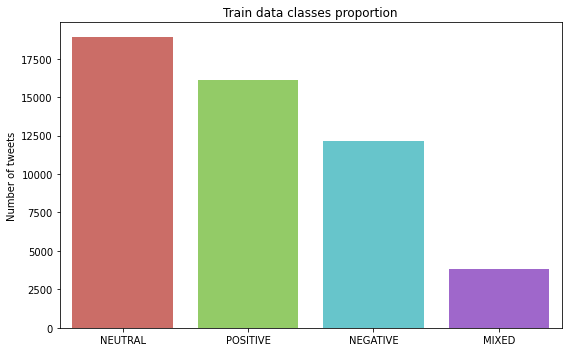

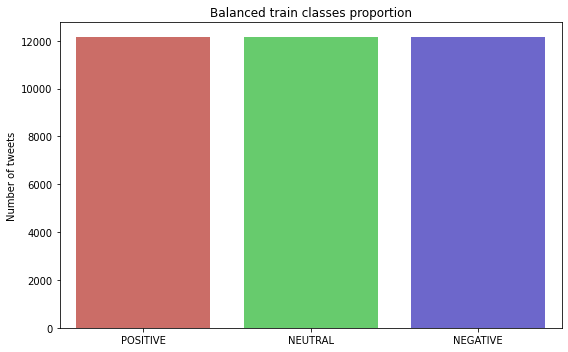

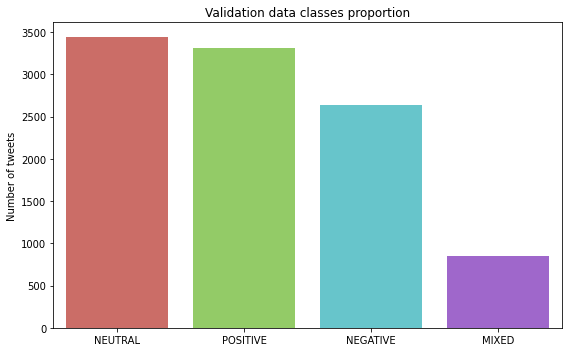

Loading Spacy..


In [23]:
model_dir=pathlib.Path('model') # Location of output model directory
train_dir=pathlib.Path('train') # Location of training file or directory
val_dir=pathlib.Path('validation') # Location of development file or directory

print("Reading data...")
train_texts, train_labels = read_data(train_dir, title="Train data classes proportion", balance=True)
val_texts, val_labels = read_data(val_dir, title="Validation data classes proportion")

train_labels = np.asarray(train_labels, dtype='f')
val_labels = np.asarray(val_labels, dtype='f')

print("Loading Spacy..")
nlp = spacy.load(SPACY_CORE_MODEL)

# Add emoji detection
emoji = Emoji(nlp, merge_spans = False)
nlp.add_pipe(emoji, first = True)

# Add tokenizer
nlp.add_pipe(nlp.create_pipe("sentencizer"))

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.optimizers import Adam

shape = {
    "nr_hidden": 64,
    "max_length": 140,
    "nr_class": 3
}
settings = {
    "dropout": 0.5,
    "lr": 0.001,
    "nb_epoch": 10,
    "batch_size": batch_size,
}
embeddings = SentimentAnalyser.get_embeddings(nlp.vocab)

model = Sequential()
model.add(
    Embedding(
        embeddings.shape[0],
        embeddings.shape[1],
        input_length=shape["max_length"],
        trainable=True,
        weights=[embeddings],
        mask_zero=True
    )
)
model.add(
    Bidirectional(
        LSTM(
            shape["nr_hidden"],
            recurrent_dropout=settings["dropout"],
            dropout=settings["dropout"],
        )
    )
)
model.add(Dense(shape["nr_class"], activation="softmax"))
model.compile(
    optimizer=Adam(lr=settings["lr"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [0]:
train_docs = list(nlp.pipe(train_texts))
val_docs = list(nlp.pipe(val_texts))

train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
val_docs, val_labels = get_labelled_sentences(val_docs, val_labels)

train_X = get_features(train_docs, shape["max_length"])
val_X = get_features(val_docs, shape["max_length"])

In [26]:
history = model.fit(
    train_X,
    train_labels,
    validation_data=(val_X, val_labels),
    epochs=settings["nb_epoch"],
    batch_size=settings["batch_size"],
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40161 samples, validate on 10390 samples
Epoch 1/10
40161/40161 [==============================] - 227s 6ms/step - loss: 0.9304 - accuracy: 0.5540 - val_loss: 0.7896 - val_accuracy: 0.6571
Epoch 2/10
40161/40161 [==============================] - 222s 6ms/step - loss: 0.7969 - accuracy: 0.6440 - val_loss: 0.7187 - val_accuracy: 0.6936
Epoch 3/10
40161/40161 [==============================] - 220s 5ms/step - loss: 0.7233 - accuracy: 0.6864 - val_loss: 0.6786 - val_accuracy: 0.7141
Epoch 4/10
40161/40161 [==============================] - 219s 5ms/step - loss: 0.6754 - accuracy: 0.7135 - val_loss: 0.6699 - val_accuracy: 0.7204
Epoch 5/10
40161/40161 [==============================] - 219s 5ms/step - loss: 0.6458 - accuracy: 0.7268 - val_loss: 0.6670 - val_accuracy: 0.7228
Epoch 6/10
40161/40161 [==============================] - 217s 5ms/step - loss: 0.6172 - accuracy: 0.7419 - val_loss: 0.6749 - val_accuracy: 0.7227
Epoch 7/10
40161/40161 [==============================] - 218s

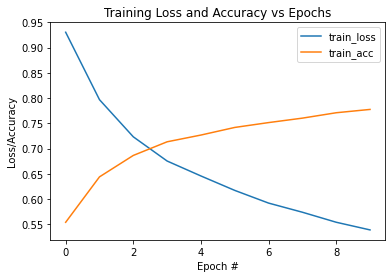

In [27]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.title('Training Loss and Accuracy vs Epochs')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')

In [0]:
# Save model
weights = model.get_weights()

if model_dir is not None:
    with (model_dir / "model").open("wb") as file_:
        pickle.dump(weights[1:], file_)
    with (model_dir / "config.json").open("w") as file_:
        file_.write(model.to_json())

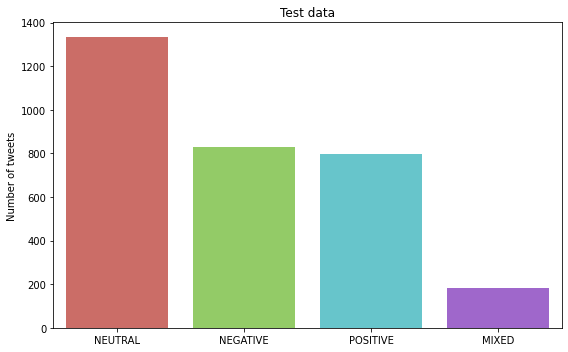

Test accuracy: 0.6503378378378378


In [31]:
# Evaluate
evaluate_nlp = spacy.load(SPACY_CORE_MODEL)
emoji = Emoji(evaluate_nlp, merge_spans = False)
evaluate_nlp.add_pipe(emoji, first = True)
evaluate_nlp.add_pipe(evaluate_nlp.create_pipe("sentencizer"))
evaluate_nlp.add_pipe(SentimentAnalyser.load(evaluate_nlp, model, weights[1:]))

test_texts, test_labels = read_data(pathlib.Path('test'), title="Test data")

predictions = SentimentAnalyser.predict(evaluate_nlp, test_texts)
correct = 0
for i, prediction in enumerate(predictions):
    correct += prediction == np.argmax(test_labels[i]) - 1

print("Test accuracy: {}".format(float(correct) / i))